Get averages for times of day

In [151]:
#read in relevant packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyproj #for utm
#pyproj.datadir.get_data_dir()
pyproj.datadir.set_data_dir('C:\\Users\\rpkamakura\\AppData\\Local\\anaconda3\\envs\\wrf\\Library\\share\\proj') #should be whatever env you're using
#to make sure you can see the env: https://stackoverflow.com/questions/53004311/how-to-add-conda-environment-to-jupyter-lab 
import math #for distances

from netCDF4 import Dataset #for using wrf.getvar
from scipy.spatial import cKDTree


##dates
import datetime

#to get a list of the files in the folder
import glob 

##attempt to reformat the netcdf in one line
import xwrf

#to quickly calculate relative humidity
import wrf


Going to need to try to average at different time points to get an overall sense of the differences

Also want to actually store those values somewhere, with information on the land use and distance from the coast for each point

Then you can do a quick regression to see how the differences between the two time points (MHW - non) vary with land use and distance to the water, with pixel location as a random effect. Basically:

MHW temp ~ 1|pixel + land use + distance to water x time of day
nonMHW temp ~ 1|pixel + land use + distance to water x time of day

and see how those two compare?

Steps for this include:
* mask out the water
* acquire a representation of the coastline
* find the distance to this coastline for each pixel
* shift the dataframe to a row for each pixel at each hour time point with temperature as the value (and/or humidity)
* add the land use and distance to water as constants
* run the regression

Questions as doing so:
* should we average the pixel values at a given time of day across the days or just have each as an observation? If you average it, you would average out some of the noise in the data but would lose data points and would have less for the pixel random effect to capture. For the question you are asking, I lean towards averaging still by time of day
* Then would need to do that right before or after masking out the water

Resources:
* averaging: https://stackoverflow.com/questions/67868777/averaging-multiple-netcdf4-files-with-python

In [22]:
##trying this with wrf-python instead to see if it makes it at all easier
#d02_2016_names = glob.glob("../Houston_MarineHeatWave_2016/wrfout_MarineHeatWave.d02.*")
d02_2017_names = glob.glob("../Houston_MarineHeatWave_2017/wrfout_MarineHeatWave.d02.*")

#pull out the datasets
#wrfin = [Dataset(f) for f in d02_2016_names]
wrfin = [Dataset(f) for f in d02_2017_names]
T2_data = wrf.getvar(wrfin, "T2", timeidx=wrf.ALL_TIMES)
rh2_data = wrf.getvar(wrfin, "rh2", timeidx=wrf.ALL_TIMES)

##Version of the above but with xarray

#start with 2016 data
d02_2016_names = glob.glob("../Houston_MarineHeatWave_2016/wrfout_MarineHeatWave.d02.*")

#merge the datasets into one stack
initial_ds = xr.open_dataset(d02_2016_names[4]).xwrf.postprocess()

#initial_ds
initial_2mTemp = initial_ds.T2
merged_2mTemp = initial_2mTemp
for file in d02_2016_names[5:]:
    ds = xr.open_dataset(file).xwrf.postprocess() #need to specify netcdf4 maybe? 
    ds_2mTemp = ds.T2
    merged_2mTemp = xr.merge([merged_2mTemp, ds_2mTemp])

DatesList = merged_2mTemp.coords['Time'].values


In [29]:
##now get the average values for each hour
DatesList = T2_data.coords['Time'].values
HourList = []

#get the dates you need
for dt in DatesList:
    full = datetime.datetime.strptime(str(dt.astype('datetime64[D]')), "%Y-%m-%d")
    hrs = pd.Timestamp(dt)
    HourList.append(hrs.hour)


#Go thorugh and get the hour-level means
#there has to be a better way of doing this...
for h in list(range(0,24)):
    
    hr_pos = [index for index, element in enumerate(HourList) if element == h]
    rel_times = DatesList[hr_pos]
    subgroup_T2 = T2_data.sel(Time = rel_times) #get the data across days at that hour
    subgroup_rh2 = rh2_data.sel(Time = rel_times)
    
    #get the mean for each pixel
    subgroup_T2_mean = subgroup_T2.mean(dim = ['Time'])
    subgroup_rh2_mean = subgroup_rh2.mean(dim = ['Time'])

    #this is hideous, has to be a better way to store the info before combining
    if h==0:
        d0_T2 = subgroup_T2_mean
        d0_rh2 = subgroup_rh2_mean
    elif h==1:
        d1_T2 = subgroup_T2_mean
        d1_rh2 = subgroup_rh2_mean
    elif h==2:
        d2_T2 = subgroup_T2_mean
        d2_rh2 = subgroup_rh2_mean
    elif h==3:
        d3_T2 = subgroup_T2_mean
        d3_rh2 = subgroup_rh2_mean
    elif h==4:
        d4_T2 = subgroup_T2_mean
        d4_rh2 = subgroup_rh2_mean
    elif h==5:
        d5_T2 = subgroup_T2_mean
        d5_rh2 = subgroup_rh2_mean
    elif h==6:
        d6_T2 = subgroup_T2_mean
        d6_rh2 = subgroup_rh2_mean
    elif h==7:
        d7_T2 = subgroup_T2_mean
        d7_rh2 = subgroup_rh2_mean
    elif h==8:
        d8_T2 = subgroup_T2_mean
        d8_rh2 = subgroup_rh2_mean
    elif h==9:
        d9_T2 = subgroup_T2_mean
        d9_rh2 = subgroup_rh2_mean
    elif h==10:
        d10_T2 = subgroup_T2_mean
        d10_rh2 = subgroup_rh2_mean
    elif h==11:
        d11_T2 = subgroup_T2_mean
        d11_rh2 = subgroup_rh2_mean
    elif h==12:
        d12_T2 = subgroup_T2_mean
        d12_rh2 = subgroup_rh2_mean
    elif h==13:
        d13_T2 = subgroup_T2_mean
        d13_rh2 = subgroup_rh2_mean
    elif h==14:
        d14_T2 = subgroup_T2_mean
        d14_rh2 = subgroup_rh2_mean
    elif h==15:
        d15_T2 = subgroup_T2_mean
        d15_rh2 = subgroup_rh2_mean
    elif h==16:
        d16_T2 = subgroup_T2_mean
        d16_rh2 = subgroup_rh2_mean
    elif h==17:
        d17_T2 = subgroup_T2_mean
        d17_rh2 = subgroup_rh2_mean
    elif h==18:
        d18_T2 = subgroup_T2_mean
        d18_rh2 = subgroup_rh2_mean
    elif h==19:
        d19_T2 = subgroup_T2_mean
        d19_rh2 = subgroup_rh2_mean
    elif h==20:
        d20_T2 = subgroup_T2_mean
        d20_rh2 = subgroup_rh2_mean
    elif h==21:
        d21_T2 = subgroup_T2_mean
        d21_rh2 = subgroup_rh2_mean
    elif h==22:
        d22_T2 = subgroup_T2_mean
        d22_rh2 = subgroup_rh2_mean
    elif h==23:
        d23_T2 = subgroup_T2_mean
        d23_rh2 = subgroup_rh2_mean


#I think you have to do this at the end - or at least have not figured out how to avoid it rn
HourlyXYMeans_2mTemp = xr.concat([d0_T2, d1_T2, d2_T2, d3_T2, d4_T2, d5_T2, d6_T2, d7_T2, 
                                  d8_T2, d9_T2, d10_T2, d11_T2, d12_T2, d13_T2, d14_T2, 
                                  d15_T2, d16_T2, d17_T2, d18_T2, d19_T2, d20_T2, d21_T2, 
                                  d22_T2, d23_T2], 
                                 pd.Index(list(range(0,24)), name='hour'))
HourlyXYMeans_RelHum = xr.concat([d0_rh2, d1_rh2, d2_rh2, d3_rh2, d4_rh2, d5_rh2, d6_rh2, 
                                  d7_rh2, d8_rh2, d9_rh2, d10_rh2, d11_rh2, d12_rh2, d13_rh2, 
                                  d14_rh2, d15_rh2, d16_rh2, d17_rh2, d18_rh2, d19_rh2, 
                                  d20_rh2, d21_rh2, d22_rh2, d23_rh2], 
                                 pd.Index(list(range(0,24)), name='hour'))
        
#HourlyXYMeans_2mTemp #to see if it works and look at attributes

<xarray.DataArray 'T2' (hour: 24, south_north: 225, west_east: 230)> Size: 5MB
array([[[292.5862 , 292.3616 , 292.24542, ..., 291.99222, 291.99615,
         292.00388],
        [292.1958 , 292.4344 , 292.28674, ..., 291.98718, 291.99146,
         292.00085],
        [292.2957 , 292.4178 , 292.26892, ..., 291.9877 , 291.99265,
         292.0015 ],
        ...,
        [292.94678, 292.54166, 292.47516, ..., 291.53644, 291.42523,
         292.018  ],
        [292.94382, 292.61322, 292.83835, ..., 290.978  , 292.26462,
         292.46573],
        [292.8344 , 292.78165, 292.7454 , ..., 291.34274, 291.44888,
         292.47653]],

       [[291.34445, 288.27386, 287.6621 , ..., 292.13733, 292.14343,
         292.15063],
        [287.13806, 288.62067, 287.9001 , ..., 292.12097, 292.12946,
         292.13812],
        [287.86957, 288.547  , 287.8626 , ..., 292.10666, 292.116  ,
         292.12872],
...
        [294.17154, 294.0481 , 293.97104, ..., 293.88467, 293.92618,
         294.11203],
        [294.1518 , 294.04373, 294.0015 , ..., 293.79092, 294.139  ,
         294.18906],
        [294.11517, 294.00195, 293.94107, ..., 293.81015, 293.8745 ,
         294.15897]],

       [[293.12753, 293.35196, 293.3082 , ..., 291.9341 , 291.94656,
         291.9603 ],
        [293.3354 , 293.4097 , 293.35477, ..., 291.92233, 291.93362,
         291.94907],
        [293.39734, 293.4501 , 293.3738 , ..., 291.91367, 291.92496,
         291.9398 ],
        ...,
        [293.85065, 293.68777, 293.6105 , ..., 293.30756, 293.32736,
         293.54794],
        [293.83417, 293.69205, 293.6925 , ..., 293.17267, 293.66727,
         293.71402],
        [293.78452, 293.67093, 293.61966, ..., 293.22678, 293.28445,
         293.69803]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 207kB -96.51 -96.5 ... -94.18
    XLAT     (south_north, west_east) float32 207kB 28.71 28.71 ... 30.69 30.69
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: south_north, west_east

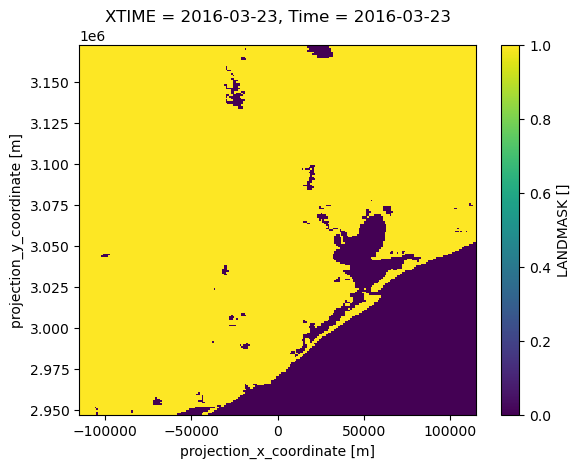

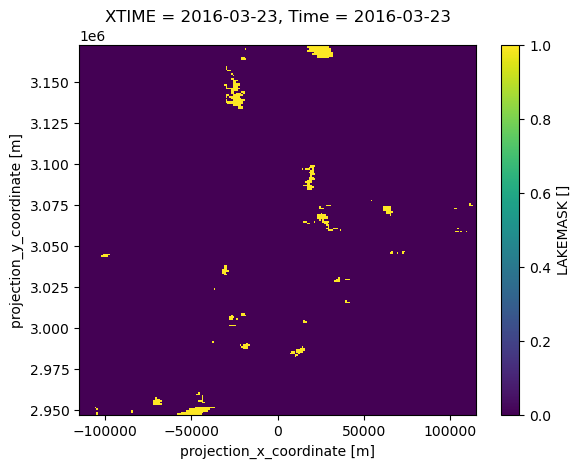

In [30]:
##figure out the coastline to do distance to coastline
#https://stackoverflow.com/questions/45440700/calculate-distance-to-shore-or-coastline-for-a-vessel
#https://gis.stackexchange.com/questions/99755/how-to-find-the-distance-to-the-nearest-coastline-from-a-land-based-latitude-lon
#might want to use cdist from scipy.spatial.distance or np.min to find minimum distance

#get just one time period
initial_ds = xr.open_dataset(d02_2016_names[0]).xwrf.postprocess()
init_ds = initial_ds.isel(Time=0)

#maybe pull LANDMASK to get the water vs land coordinates
#the grid cells should all be the same so can just use the initial run
overall_Landsmask = init_ds.LANDMASK

fig = plt.figure()
overall_Landsmask.plot.imshow()

#so need to then include the lakes as part of the land
lakes = init_ds.LAKEMASK

fig = plt.figure()
lakes.plot.imshow()

In [31]:
#Need a raster of each, this currently does not work
##try to sum the two masks to create a raster where 
#landpx: landmask = 1 | lakemask = 1

#this is effectively an actual ocean mask
nonOcean = overall_Landsmask + lakes

#now can create two dfs that have nans either where there is ocean or where there is land
nonOcean_wnan = nonOcean.where(nonOcean.values == 1)
Ocean_wnan = nonOcean.where(nonOcean.values == 0)

#nonOcean_wnan


In [32]:
##try to figure out closest distance to ocean for each land point

Ocean_lats = Ocean_wnan.coords['XLAT'].values
Ocean_lons = Ocean_wnan.coords['XLONG'].values

#I think should be able to select the coordinates this way???
Ocean_indices = np.isnan(nonOcean_wnan.values)

#do the selection and should have pairs of each
Ocean_lats_nn = Ocean_lats[Ocean_indices]
Ocean_lons_nn = Ocean_lons[Ocean_indices]

In [33]:
##now do the same for the land points
nonOcean_lats = nonOcean_wnan.coords['XLAT'].values
nonOcean_lons = nonOcean_wnan.coords['XLONG'].values

#I think should be able to select the coordinates this way???
nonOcean_indices = np.isnan(Ocean_wnan.values)

#do the selection and should have pairs of each
nonOcean_lats_nn = nonOcean_lats[nonOcean_indices]
nonOcean_lons_nn = nonOcean_lons[nonOcean_indices]

In [49]:
##to change lat long into UTM
p = pyproj.Proj(proj='utm', zone=15, ellps='WGS84')

minDists_land2ocean = []

##Now calculate the minimum distance to the ocean for each land point
land_list = list(range(0, len(nonOcean_lats_nn)))
ocean_list = list(range(0, len(Ocean_lats_nn)))
for i in land_list:
    x1,y1 = p(nonOcean_lons_nn[i], nonOcean_lats_nn[i])
    
    min_dist = 100000000
    
    for j in ocean_list:
        x2,y2 = p(Ocean_lons_nn[j], Ocean_lats_nn[j])
        dist = math.dist([x1, y1], [x2, y2])

        if dist < min_dist:
            min_dist = dist

    #end of ocean for loop
    minDists_land2ocean = np.append(minDists_land2ocean, min_dist)

#end of big for loop
#minDists_land2ocean

Next step, pull land use for each pixel as well

This should be easier because you don't have to really calculate anything, just need the data in a useable format

In [52]:
##land use - a predictor
landuse = initial_ds.LU_INDEX


Goal: shift the dataframe to a row for each pixel at each hour time point with temperature as the value (and/or humidity)

So the columns should be
|  gridCell  |  Lat  |  Long  |  Hour  |  Temperature  | Humidity  |  Dist2Ocean  |

We should have 225 unique grid cells and 24 hours

In [ ]:
##indexing by lat/long is an issue here because it is in an odd grid format
#maybe try this? https://xoak.readthedocs.io/en/latest/examples/dask_support.html

In [167]:
#initialize your df
nrows=41967*24
ncols = 7
column_names = ['GridCell', 'lat', 'long', 'hour', '2mTemp', 'RelHumid', 'Dist2Ocean']
HourlyMeans_arr = np.zeros((nrows, ncols))

#this is not quite right, need each to be repeated 24 times (for each hour of the day)
HourlyMeans_arr[:,0] = list(range(1,41968))*24
HourlyMeans_arr[:,1] = [item for _ in range(24) for item in nonOcean_lats_nn]
HourlyMeans_arr[:,2] = [item for _ in range(24) for item in nonOcean_lons_nn]
HourlyMeans_arr[:,6] = [item for _ in range(24) for item in minDists_land2ocean]

#have to go extract the coordinates of this weird 2D coordinate array system to deal with indexing later
latitudes = HourlyXYMeans_2mTemp.coords['south_north'].values
longitudes = HourlyXYMeans_2mTemp.coords['west_east'].values



#for each hour
iter = 0
for h in list(range(0,24)):

    #h index is easy, they are in numerical order
    
    for p in list(range(0,41967)):
        #go through and get the lat/lon
        plat=nonOcean_lats_nn[p]
        plon=nonOcean_lons_nn[p]
    
        #get the 2m temps at that lat/lon at that hour
        lat_idx = (np.abs(latitudes - plat)).argmin()
        lon_idx = (np.abs(longitudes - plon)).argmin()
        
        temp2m = HourlyXYMeans_2mTemp.isel(south_north=lat_idx, west_east=lon_idx, hour=h)
        rh2m = HourlyXYMeans_RelHum.isel(south_north=lat_idx, west_east=lon_idx, hour=h)
        #rh2m = HourlyXYMeans_RelHum.isel(XLAT=plat, XLONG=plon, hour=h)

        #add that value to the df
        HourlyMeans_arr[iter,3] = h
        HourlyMeans_arr[iter,4] = temp2m
        HourlyMeans_arr[iter,5] = rh2m

        #increase iter
        iter += 1

        
#once ready
HourlyMeans_df = pd.DataFrame(HourlyMeans_arr, columns=column_names)




In [171]:
HourlyMeans_df.to_csv('HourlyMeans_2016_021025.csv', index=False)